# Global Green Energy Part 7: Predictive Analytics & Forecasting 🔮

This final chapter applies machine learning techniques to predict energy access patterns and forecast future trends. We use Random Forest regression for feature importance analysis, develop country-specific predictive models, and create forecasting systems to project electricity access trajectories through 2030. This represents the culmination of our analytical journey from descriptive statistics to predictive modeling.

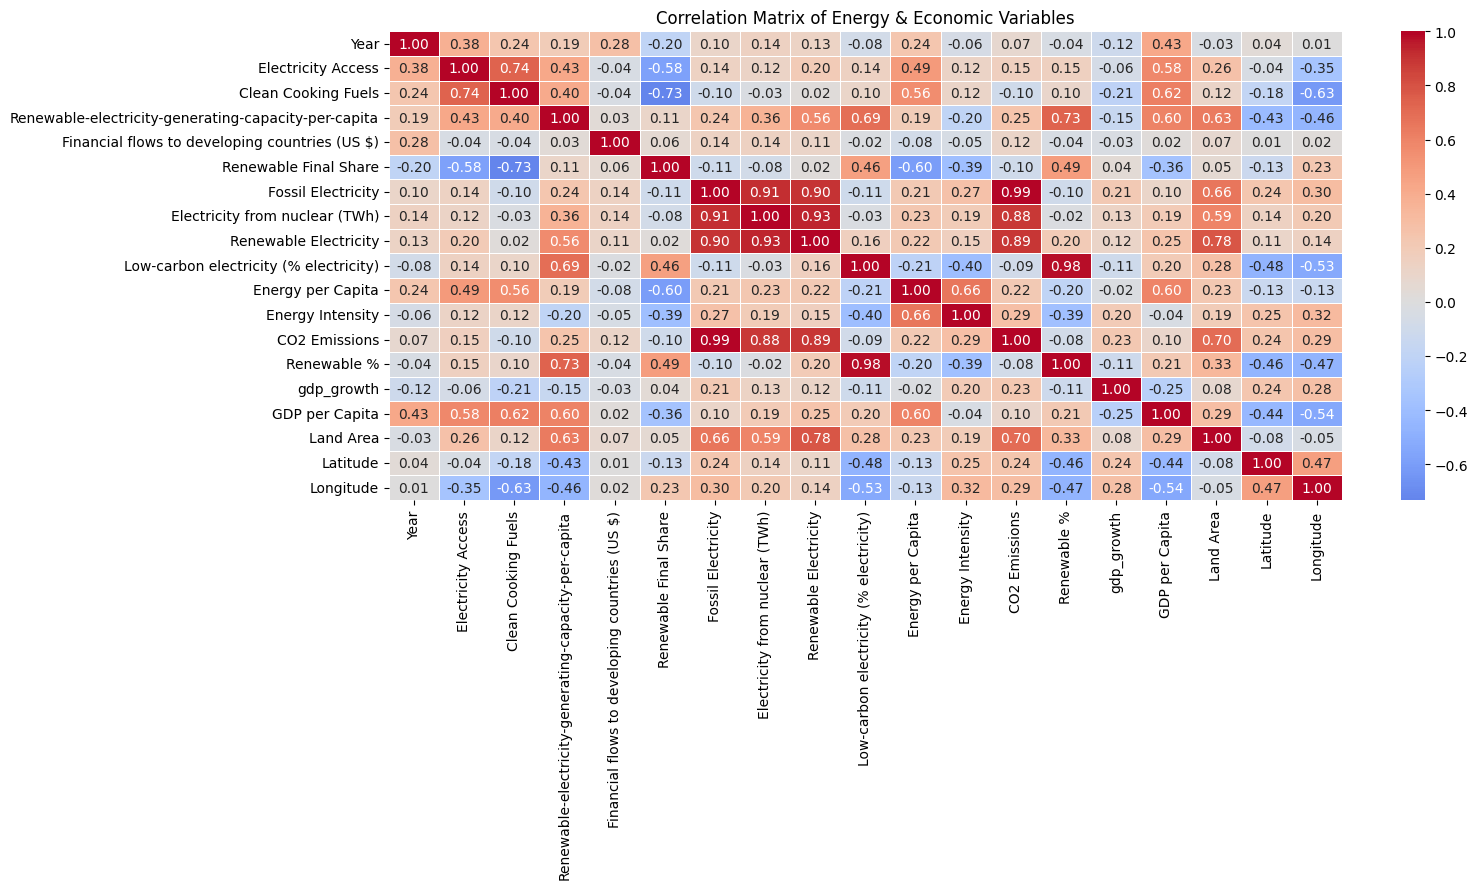

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from math import sqrt

# Load in data
raw_data = pd.read_csv('../day18/global_sustainable_energy_data.csv')
df = raw_data.copy()

# Select only numeric columns
df_num = df.select_dtypes(include="number")

# Drop missing values (or fillna if needed)
df_corr = df_num.dropna()

# Correlation matrix
corr_matrix = df_corr.corr()

# Rename variable names
var_name_mapping = {
    'Electricity from fossil fuels (TWh)': 'Fossil Electricity',
    'Electricity from renewables (TWh)': 'Renewable Electricity', 
    'Energy intensity level of primary energy (MJ/$2017 PPP GDP)': 'Energy Intensity',
    'Primary energy consumption per capita (kWh/person)': 'Energy per Capita',
    'Renewables (% equivalent primary energy)': 'Renewable %',
    'Value_co2_emissions_kt_by_country': 'CO2 Emissions',
    'gdp_per_capita': 'GDP per Capita',
    'Access to electricity (% of population)': 'Electricity Access',
    'Access to clean fuels for cooking': 'Clean Cooking Fuels',
    'Land Area(Km2)': 'Land Area',
    'Rebewable-electricity-generating-capacity-per-capita': 'Renewable Capacity per Capita',
    'Renewable energy share in the total final energy consumption (%)': 'Renewable Final Share',
}

# Apply renaming to rows and columns in correlation matrix
corr_matrix.rename(index=var_name_mapping, columns=var_name_mapping, inplace=True)

# Plot
plt.figure(figsize=(16, 9))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Correlation Matrix of Energy & Economic Variables")
plt.tight_layout()
plt.show()

## Foundation for Prediction: Enhanced Correlation Analysis

Starting with a refined correlation matrix using cleaner variable names establishes our predictive modeling foundation:
- **Feature relationship mapping** - understanding correlations guides feature selection for machine learning models and helps identify potential multicollinearity issues
- **Predictive signal identification** - variables showing strong correlations with our target (electricity access) provide the strongest predictive signals for supervised learning algorithms

R² Score: 0.968
RMSE: 2.56


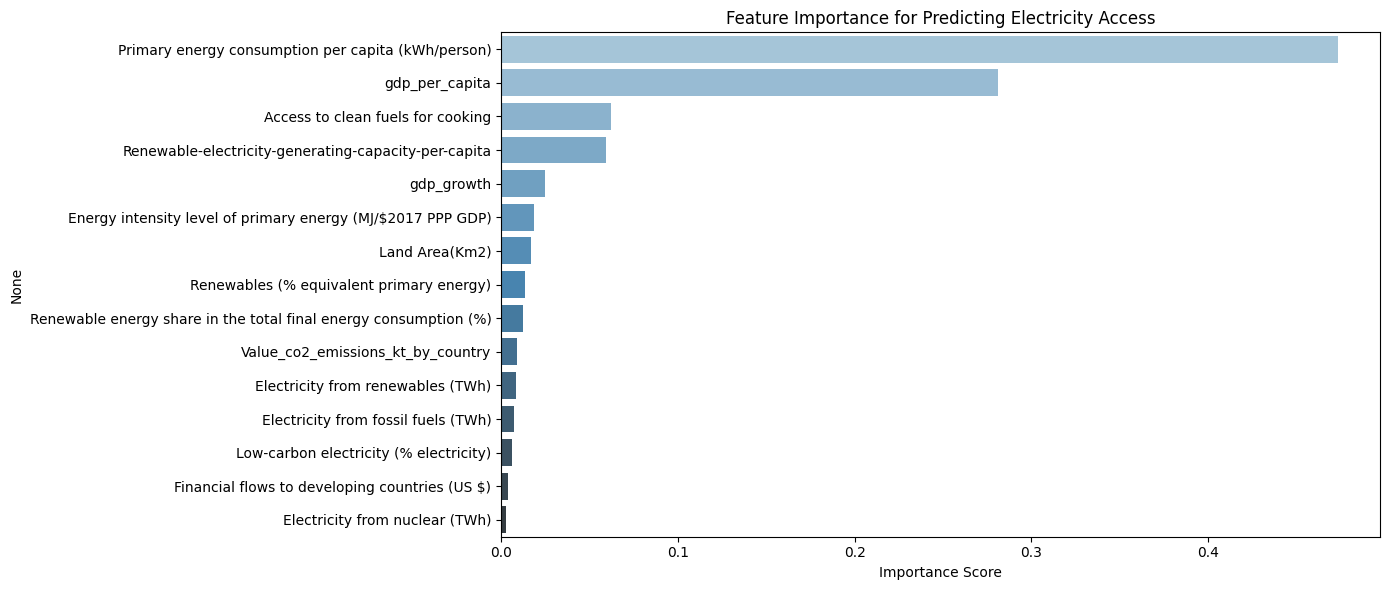

In [40]:
# Step 1: Prepare target and features
target = 'Access to electricity (% of population)'
drop_cols = ['Year', 'Latitude', 'Longitude', target]
features = df.select_dtypes(include='number').drop(columns=drop_cols, errors='ignore').columns.tolist()

df_model = df[[target] + features].dropna()

X = df_model[features]
y = df_model[target]

# Step 2: Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Step 4: Predict and evaluate
y_pred = model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.2f}")

# Step 5: Feature importances
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(
    x=importances.values,
    y=importances.index,
    palette='Blues_d', 
    hue = importances.index
)
plt.title('Feature Importance for Predicting Electricity Access')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

## Global Predictive Model: Random Forest Insights

The Random Forest regression reveals which factors most strongly predict electricity access globally:
- **Model performance validation** - strong R² and low RMSE scores indicate our feature set effectively captures the underlying patterns in electricity access across countries
- **Feature importance hierarchy** - the ranked importance scores identify which economic, energy, and development indicators are most critical for predicting electricity access, providing data-driven insights for policy prioritization

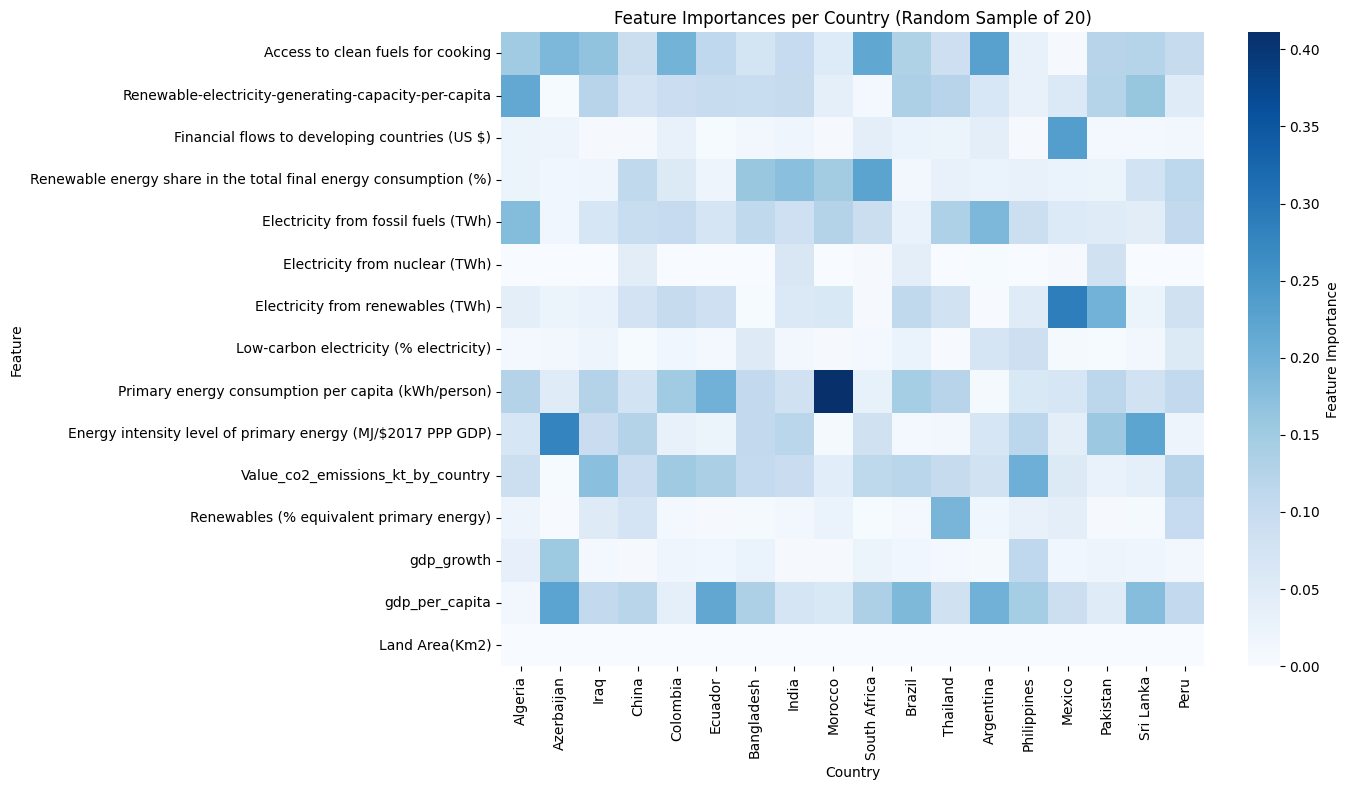

In [42]:
# Ensure target + features + Entity are present
df_complete = df[['Entity'] + [target] + features].dropna()

# Group and filter for countries with ≥10 usable rows
valid_countries = (
    df_complete.groupby('Entity').size()
    .loc[lambda x: x >= 10]
    .index
)

# Sample 20 countries from valid ones
sample_size = min(20, len(valid_countries))
sample_countries = np.random.choice(valid_countries, size=sample_size, replace=False)

# Filter df to only those countries once
df_filtered = df_complete[df_complete['Entity'].isin(sample_countries)]

# Loop over countries and compute importances
country_importances = []

for country in sample_countries:
    df_c = df_filtered[df_filtered['Entity'] == country]
    X = df_c[features]
    y = df_c[target]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_scaled, y)

    importance = pd.Series(model.feature_importances_, index=features).rename(country)
    country_importances.append(importance)

# Combine and plot
df_country_imp = pd.DataFrame(country_importances).T

plt.figure(figsize=(14, 8))
sns.heatmap(df_country_imp.fillna(0), cmap='Blues', cbar_kws={"label": "Feature Importance"})
plt.title('Feature Importances per Country (Random Sample of 20)')
plt.xlabel('Country')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## Country-Specific Model Analysis: Local Predictive Patterns

The country-by-country feature importance heatmap reveals how predictive factors vary across different national contexts:
- **Context-specific drivers** - different countries show distinct patterns in which variables best predict electricity access, reflecting diverse development pathways and resource endowments
- **Universal versus local factors** - comparing across countries identifies which predictive features are globally consistent versus those that vary by national context, informing targeted versus universal policy approaches

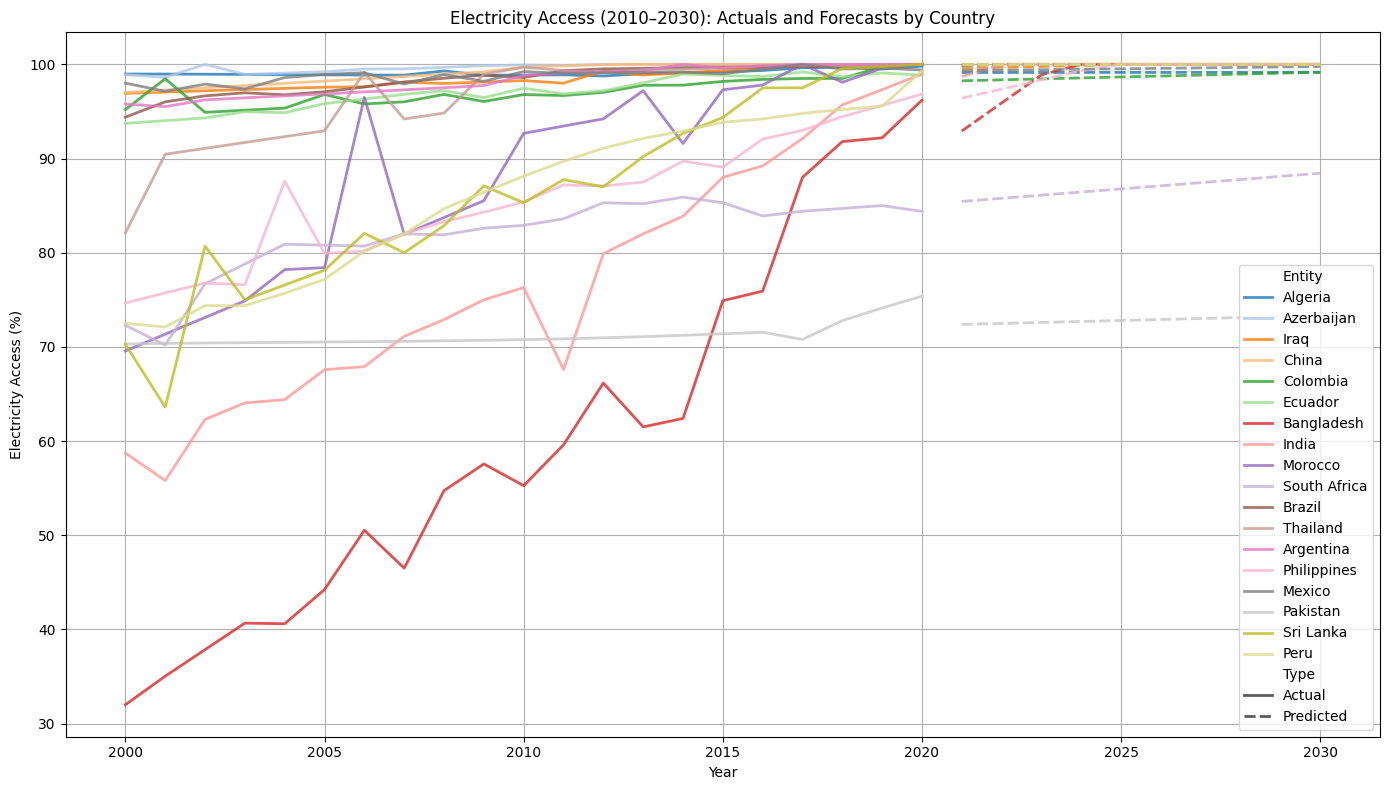

In [43]:
years_past = list(range(2010, 2021))
years_future = list(range(2021, 2031))

df_forecast = df[df['Entity'].isin(sample_countries)].copy()

df_forecast = df_forecast[['Entity', 'Year', 'Access to electricity (% of population)', 'gdp_per_capita']].dropna()

df_forecast.rename(columns={
    'Access to electricity (% of population)': 'ElectricityAccess',
    'gdp_per_capita': 'GDPperCapita'
}, inplace=True)

all_preds = []

for country in sample_countries:
    country_data = df_forecast[df_forecast['Entity'] == country]
    
    gdp_model = LinearRegression()
    gdp_model.fit(country_data[['Year']], country_data['GDPperCapita'])
    
    future_years = pd.DataFrame({'Year': years_future})
    gdp_future = gdp_model.predict(future_years)
    
    access_model = LinearRegression()
    access_model.fit(country_data[['GDPperCapita']], country_data['ElectricityAccess'])
    
    # Wrap gdp predictions in DF with same column name
    gdp_future_df = pd.DataFrame(gdp_future, columns=['GDPperCapita'])
    
    access_future = access_model.predict(gdp_future_df)
    access_future = np.clip(access_future, 0, 100)
    
    past_df = country_data[['Entity', 'Year', 'ElectricityAccess']].copy()
    past_df['Type'] = 'Actual'
    
    future_df = pd.DataFrame({
        'Entity': country,
        'Year': years_future,
        'ElectricityAccess': access_future,
        'Type': 'Predicted'
    })
    
    all_preds.append(past_df)
    all_preds.append(future_df)

df_pred_all = pd.concat(all_preds, ignore_index=True)

plt.figure(figsize=(14, 8))
sns.lineplot(
    data=df_pred_all,
    x='Year', y='ElectricityAccess',
    hue='Entity', style='Type',
    palette='tab20',
    lw=2, alpha=0.8
)
plt.title("Electricity Access (2010–2030): Actuals and Forecasts by Country")
plt.ylabel("Electricity Access (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Predictive Forecasting: 2030 Electricity Access Projections

The forecasting model combines economic growth predictions with electricity access relationships to project future outcomes:
- **Two-stage modeling approach** - first predicting GDP growth trajectories, then using those predictions to forecast electricity access creates a realistic causal chain linking economic development to energy infrastructure
- **Trend extrapolation insights** - the 2030 projections reveal which countries are on track to achieve universal electricity access and which may require targeted interventions to accelerate progress

# Global Green Energy Analysis: Complete Journey Synthesis

## Analytical Evolution: From Description to Prediction

This seven-part analysis series represents a comprehensive journey through the modern data science toolkit applied to global energy systems:

### **Part 1-3: Exploratory Foundation**
We began with clustering renewable energy adoption patterns, explored geographic and economic relationships, and developed dynamic visualizations. These initial phases established the descriptive foundation and revealed the complex, multi-dimensional nature of global energy transitions.

### **Part 4-5: Advanced Analytics**
The middle phases applied sophisticated techniques including multi-dimensional clustering, PCA dimensionality reduction, and income stratification analysis. These approaches uncovered energy system archetypes and revealed how development level shapes energy access patterns.

### **Part 6: Temporal Integration**
The temporal analysis combined correlation-based trend identification with clustering evolution tracking, revealing how different country archetypes develop along parallel economic-energy trajectories over time.

### **Part 7: Predictive Modeling**
This final phase applies machine learning for both explanation (feature importance) and prediction (forecasting), translating descriptive insights into actionable forecasts for policy and investment planning.

## Major Discoveries

### **Energy System Diversity**
Countries cluster into distinct energy system archetypes based on development level, resource endowments, and policy choices. These archetypes persist over time but follow parallel upward trajectories in both economic and renewable energy development.

### **Development-Energy Synergy**
Contrary to traditional development-environment tradeoffs, our analysis reveals that economic growth and renewable energy adoption are largely complementary forces, with renewable transitions becoming more feasible as countries develop economically.

### **Predictive Policy Intelligence**
Machine learning reveals which factors most strongly predict energy access outcomes, both globally and within specific country contexts. This enables evidence-based policy prioritization and targeted intervention design.

## Strategic Impact

This analytical framework provides unprecedented insight for:
- **Investment allocation** based on predictive models rather than intuition
- **Policy design** tailored to specific energy system archetypes
- **International cooperation** organized around shared development-energy trajectories
- **Progress monitoring** using data-driven forecasting to track toward universal energy access

The integration of descriptive, temporal, clustering, and predictive analytics creates a comprehensive intelligence system for understanding and accelerating global energy transitions. This represents the frontier of evidence-based sustainable development policy.